# Preparation

In [1]:
import tushare as ts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings("ignore")

In [2]:
pro = ts.pro_api()

In [3]:
def get_us_daily(ts_code, start_date):
    '''
     To get specified US stock data and formalize it
     output: A dataframe corresponds to a data
     '''
    df = pro.us_daily(ts_code = ts_code, start_date = start_date, end_date = '')
    df['trade_date'] = pd.to_datetime(df['trade_date'].astype(str), format = '%Y-%m-%d')
    df.set_index('trade_date',inplace=True)
    return df.sort_index()

In [4]:
# 可口可乐
# KO = get_us_daily(ts_code = 'KO', start_date = '20200101')

In [5]:
# 百事可乐
# PEP = get_us_daily(ts_code = 'PEP', start_date = '20200101')

In [6]:
# 高盛
# GS = get_us_daily(ts_code = 'GS', start_date = '20200101')

In [7]:
# 摩根斯坦利
# MS = get_us_daily(ts_code = 'MS', start_date = '20200101')

In [8]:
# KO.to_csv('KO.csv')
# PEP.to_csv('PEP.csv')
# GS.to_csv('GS.csv')
# MS.to_csv('MS.csv')

In [9]:
KO = pd.read_csv('KO.csv', index_col = 'trade_date')
PEP = pd.read_csv('PEP.csv', index_col = 'trade_date')
GS = pd.read_csv('GS.csv', index_col = 'trade_date')
MS = pd.read_csv('MS.csv', index_col = 'trade_date')

# KO vs PEP

## 1. 检验

### 1.1 相关性检验

In [10]:
df_t = pd.DataFrame({"c1": KO.close, "c2": PEP.close})
df_t.corr()

,c1,c2
c1,1.000000,0.886551
c2,0.886551,1.000000


### 1.2 ADF检验 （平稳性检验）

In [11]:
from statsmodels.tsa.stattools import adfuller
 
print(adfuller(KO.close))
print(adfuller(PEP.close))

(-1.4833524350113465, 0.5417299905273517, 12, 625, {'1%': -3.440856177517568, '5%': -2.86617548304384, '10%': -2.56923863104}, 1513.849308905343)
(-1.4425769495307863, 0.561702691297546, 9, 628, {'1%': -3.4408057813848147, '5%': -2.866153285929353, '10%': -2.569226804028561}, 2699.2856317699443)


As p-values are greater than 0.5, we failed to reject the null hypothesis, and need to conclude that both sequences are not stationary.

In [12]:
print(adfuller(np.diff(KO.close)))
print(adfuller(np.diff(PEP.close)))

(-7.77848687660824, 8.541953732197878e-12, 11, 625, {'1%': -3.440856177517568, '5%': -2.86617548304384, '10%': -2.56923863104}, 1512.7284993583403)
(-7.5399090326663245, 3.399724795356072e-11, 8, 628, {'1%': -3.4408057813848147, '5%': -2.866153285929353, '10%': -2.569226804028561}, 2695.8729632942927)


### 1.3 协整检验

上述结果表示，两序列一阶差分都是平稳的

In [13]:
from statsmodels.tsa.stattools import coint

print(coint(KO.close, PEP.close))

(-2.917886007302604, 0.1310364838897548, array([-3.91371556, -3.34573881, -3.05111479]))


## 2. Visualize spread and z-score

In [14]:
spread = PEP.close - KO.close

In [15]:
print(adfuller(spread))

(-1.6152375382867097, 0.4752269402845244, 9, 628, {'1%': -3.4408057813848147, '5%': -2.866153285929353, '10%': -2.569226804028561}, 2330.901260076357)


In [16]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

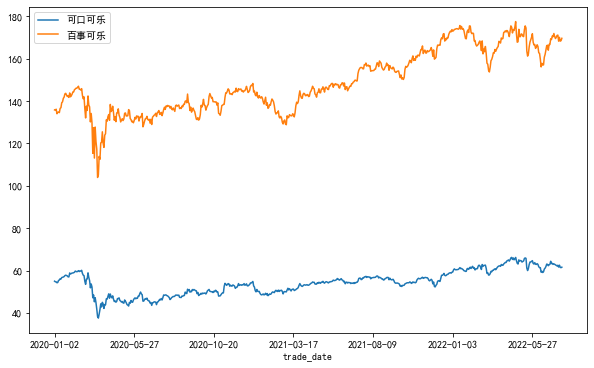

In [17]:
KO.close.plot(figsize = (10, 6), label = '可口可乐')
PEP.close.plot(figsize = (10, 6), label = '百事可乐')
plt.legend()

<AxesSubplot:xlabel='trade_date'>

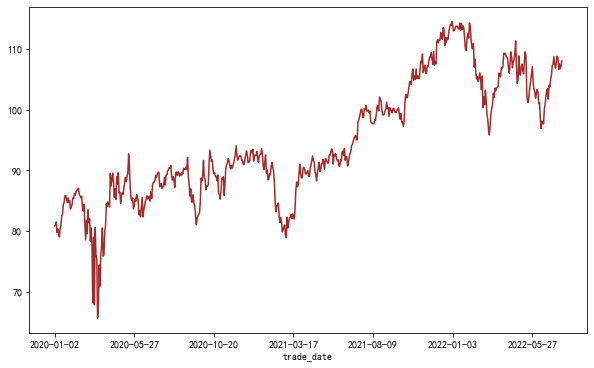

In [18]:
# spread
spread.plot(figsize = (10, 6), color = 'brown')

<AxesSubplot:xlabel='trade_date'>

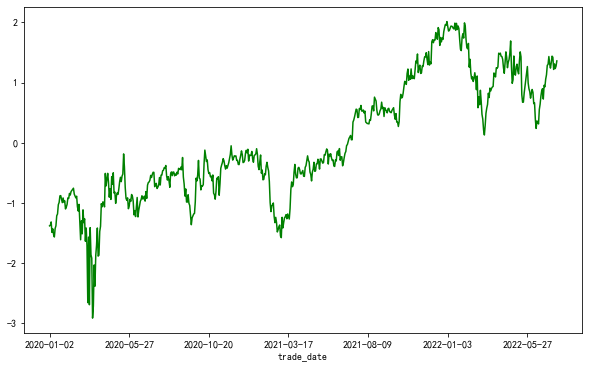

In [19]:
# z-score
z = (spread - np.mean(spread))/np.std(spread)
z.plot(figsize = (10, 6), color = 'green')

## 3. Trading Signal

In [20]:
def pair_trade(z):
    sigma = np.std(z)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(len(z)), z)
    ax.hlines(0, 0, len(z))
    ax.hlines(0.2 * sigma, 0, len(z), linestyle = '--', colors='g') # 开仓
    ax.hlines(-0.2 * sigma, 0, len(z), linestyle = '--', colors='g') # 平仓
    ax.hlines(1.5 * sigma, 0, len(z), colors='b')
    ax.hlines(-1.5 * sigma, 0, len(z), colors='b')
    ax.hlines(2.5 * sigma, 0, len(z), colors='r')
    ax.hlines(-2.5 * sigma, 0, len(z), colors='r')
    plt.show()

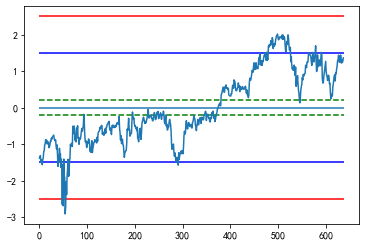

In [21]:
pair_trade(z)

In [22]:
mu = np.mean(z)
sd = np.std(z)

In [23]:
# 设置策略区间
level = (float('-inf'),mu-2.5*sd,mu-1.5*sd,mu-0.2*sd,mu+0.2*sd,mu+1.5*sd,mu+2.5*sd,float('inf'))

In [24]:
# 把交易期的价差序列按照触发区间标准分类【-3，2】
prcLevel = pd.cut(z, level, labels=False) - 3

In [25]:
np.unique(level)

array([-inf, -2.5, -1.5, -0.2,  0.2,  1.5,  2.5,  inf])

In [26]:
np.unique(prcLevel)

array([-3, -2, -1,  0,  1,  2], dtype=int64)

In [27]:
# 构造交易信号函数
def PairTradeSig(prcLevel):
    n = len(prcLevel)
    signal = np.zeros(n)
    for i in range(1,n):
        if prcLevel[i-1] == 1 and prcLevel[i] == 2: # 价差从1区上穿2区，反向建仓 (case 1)
            signal[i] = -2
        elif prcLevel[i-1] == 1 and prcLevel[i] == 0: # 价差从1区下穿0区，平仓 (case 2)
            signal[i] = 2
        elif prcLevel[i-1] == 2 and prcLevel[i] == 3: # 价差从2区上穿3区，即突破3区，平仓 (case 5)
            signal[i] = 3
        elif prcLevel[i-1] == -1 and prcLevel[i] == -2: # 价差从-1区下穿-2区，正向建仓 (case 3)
            signal[i] = 1
        elif prcLevel[i-1] == -1 and prcLevel[i] == 0: # 价差从-1区上穿0区，平仓 (case 4)
            signal[i] = -1
        elif prcLevel[i-1] == -2 and prcLevel[i] == -3: # 价差从-2区下穿-3区，即突破-3区，平仓 (case 5)
            signal[i] = -3
    return(signal)

In [28]:
# 设置每个每天的交易信号
signal = PairTradeSig(prcLevel)

**signal:**

    1: 正向建仓
    
    -1： 平仓
    
    2： 平仓
    
    -2： 反向建仓
    
    3： 平仓
    
    -3： 平仓

<AxesSubplot:xlabel='trade_date'>

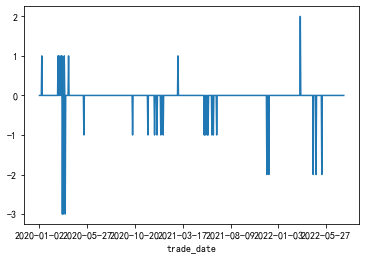

In [29]:
pd.Series(signal, index = KO.index).plot()

In [30]:
def make_position(signal, index):
    """
    Make position according to trading signal
    
    Input: signal, index (time)
    
    Output: position
    """
    position = [signal[0]]
    ns = len(signal)
    for i in range(1,ns):
        position.append(position[-1])
        if signal[i] == 1:
            position[i] = 1 # 价差从-1区下穿-2区，正向建仓: 买B卖A <------（价差为B-A), here B：茅台，A：五粮液
        elif signal[i] == -2:
            position[i] = -1 # 价差从1区上穿2区，反向建仓：卖B买A <------（价差为B-A）
        elif signal[i] == -1 and position[i-1] == 1:
            position[i] = 0 # 平仓
        elif signal[i] == 2 and position[i-1] == -1:
            position[i] = 0 # 平仓
        elif signal[i] == 3:
            position[i] = 0 # 平仓
        elif signal[i] == -3:
            position[i] = 0 # 平仓
    return pd.Series(position, index = index)

In [31]:
position = make_position(signal, KO.index)

<AxesSubplot:xlabel='trade_date'>

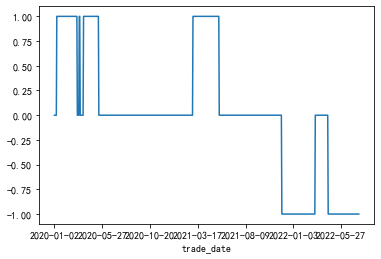

In [32]:
# 1: 正向建仓
# 0: 平仓
# -1: 反向建仓
position.plot()

## 4. Cumulative Return

In [33]:
trade = pd.DataFrame({"KO": KO.close, "PEP": PEP.close, "position": position.shift(1)})

In [34]:
trade['return'] = np.select([trade['position'] == 1, 
                             trade['position'] == 0, 
                             trade['position'] == -1], 
                            [trade['KO'] * 1 + trade['PEP'] * -1, 0, 
                             trade['KO'] * -1 + trade['PEP'] * 1], 
                            default = np.nan)

<AxesSubplot:xlabel='trade_date'>

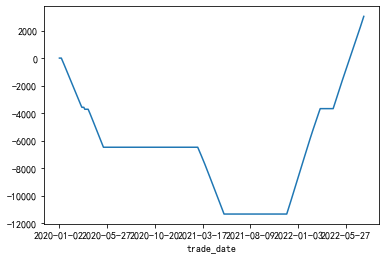

In [35]:
trade['return'].cumsum().plot()

# GS vs MS

## 1. 检验
### 1.1 相关性检验

In [36]:
df_t = pd.DataFrame({"c1": GS.close, "c2": MS.close})
df_t.corr()

,c1,c2
c1,1.000000,0.982072
c2,0.982072,1.000000


### 1.2 ADF检验 （平稳性检验）

In [37]:
from statsmodels.tsa.stattools import adfuller
 
print(adfuller(GS.close))
print(adfuller(MS.close))

(-1.0439191551281894, 0.7369108282316024, 8, 629, {'1%': -3.4407890899441127, '5%': -2.8661459340578905, '10%': -2.5692228868342766}, 3988.517503200894)
(-1.1099767999913055, 0.7110769175191456, 8, 629, {'1%': -3.4407890899441127, '5%': -2.8661459340578905, '10%': -2.5692228868342766}, 2334.762617197905)


In [38]:
print(adfuller(np.diff(GS.close)))
print(adfuller(np.diff(MS.close)))

(-8.602447226112256, 6.811243300658093e-14, 7, 629, {'1%': -3.4407890899441127, '5%': -2.8661459340578905, '10%': -2.5692228868342766}, 3982.2332130124964)
(-8.975862669139142, 7.535448039873723e-15, 7, 629, {'1%': -3.4407890899441127, '5%': -2.8661459340578905, '10%': -2.5692228868342766}, 2331.2550917455164)


### 1.3 协整性检验

In [39]:
from statsmodels.tsa.stattools import coint
print(coint(GS.close, MS.close))

(-2.6208526779420573, 0.22932533578926895, array([-3.91371556, -3.34573881, -3.05111479]))


p-value大于0.05，我们不能否决掉Null hypothesis：两序列非协整。

## 2. Visualize spread and z-score

In [40]:
spread = GS.close - MS.close

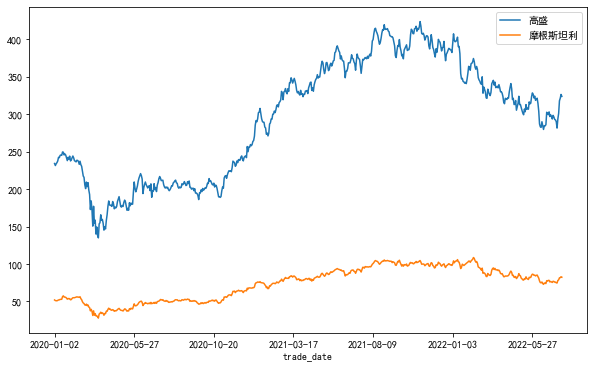

In [41]:
GS.close.plot(figsize = (10, 6), label = '高盛')
MS.close.plot(figsize = (10, 6), label = '摩根斯坦利')
plt.legend()

<AxesSubplot:xlabel='trade_date'>

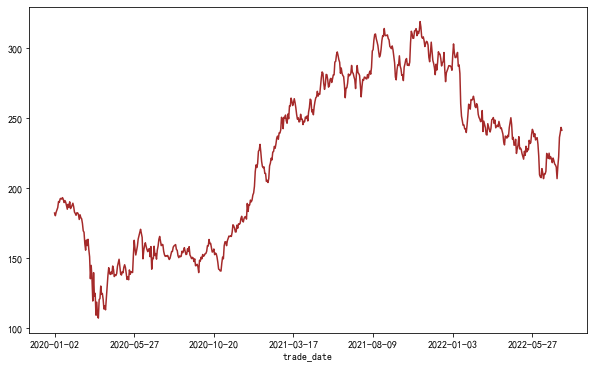

In [42]:
# spread
spread.plot(figsize = (10, 6), color = 'brown')

<AxesSubplot:xlabel='trade_date'>

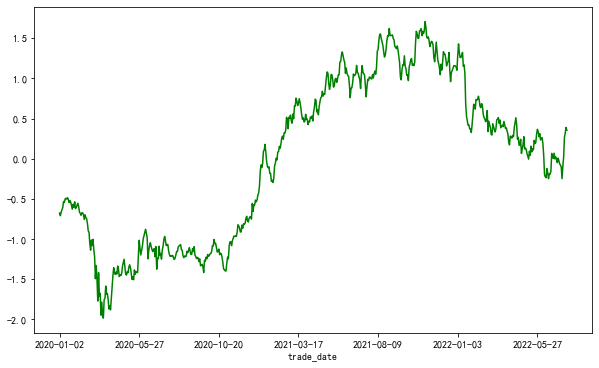

In [43]:
# z-score
z = (spread - np.mean(spread))/np.std(spread)
z.plot(figsize = (10, 6), color = 'green')

## 3. Trading Signals

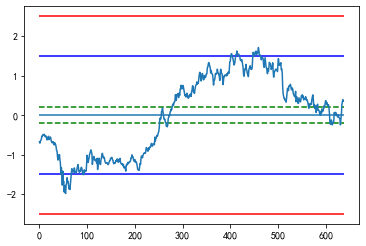

In [44]:
pair_trade(z)

In [48]:
def make_pair_trading_signal(z, s1, s2, s3):
    """
    Make trading signal for pair trading
    
    Input: 
        z: z-score of spread
        s1: set s1 times of standard deviation for 0 sector
        s2: set s2 times of standard deviation for 1 sector
        s3: set s3 times of standard deviation for 2 sector
    output:
        trading signal
    """
    mu = np.mean(z)
    sd = np.std(z)
    
    level = (float('-inf'),mu-s3*sd,mu-s2*sd,mu-s1*sd,mu+s1*sd,mu+s2*sd,mu+s3*sd,float('inf'))
    prcLevel = pd.cut(z, level, labels=False) - 3
    
    n = len(prcLevel)
    signal = np.zeros(n)
    for i in range(1,n):
        if prcLevel[i-1] == 1 and prcLevel[i] == 2: # 价差从1区上穿2区，反向建仓 (case 1)
            signal[i] = -2
        elif prcLevel[i-1] == 1 and prcLevel[i] == 0: # 价差从1区下穿0区，平仓 (case 2)
            signal[i] = 2
        elif prcLevel[i-1] == 2 and prcLevel[i] == 3: # 价差从2区上穿3区，即突破3区，平仓 (case 5)
            signal[i] = 3
        elif prcLevel[i-1] == -1 and prcLevel[i] == -2: # 价差从-1区下穿-2区，正向建仓 (case 3)
            signal[i] = 1
        elif prcLevel[i-1] == -1 and prcLevel[i] == 0: # 价差从-1区上穿0区，平仓 (case 4)
            signal[i] = -1
        elif prcLevel[i-1] == -2 and prcLevel[i] == -3: # 价差从-2区下穿-3区，即突破-3区，平仓 (case 5)
            signal[i] = -3
            
    return pd.Series(signal, index = z.index)

In [49]:
signal = make_pair_trading_signal(z, s1 = 0.2, s2 = 1.5, s3 = 2.5)

<AxesSubplot:xlabel='trade_date'>

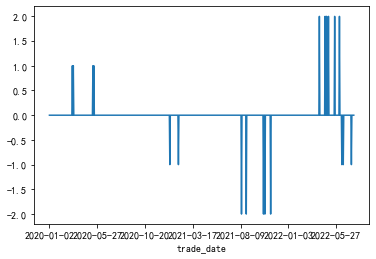

In [50]:
signal.plot()

In [51]:
position = make_position(signal, signal.index)

<AxesSubplot:xlabel='trade_date'>

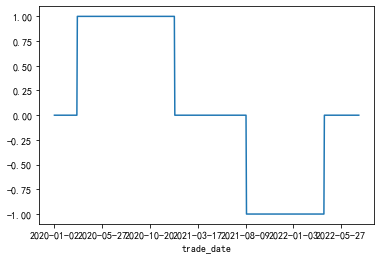

In [52]:
position.plot()

## 4. Cumulative Return

In [53]:
trade = pd.DataFrame({"GS": GS.close, "MS": MS.close, "position": position.shift(1)})

In [54]:
trade['return'] = np.select([trade['position'] == 1, 
                             trade['position'] == 0, 
                             trade['position'] == -1], 
                            [trade['GS'] * 1 + trade['MS'] * -1, 0, 
                             trade['GS'] * -1 + trade['MS'] * 1], 
                            default = np.nan)

<AxesSubplot:xlabel='trade_date'>

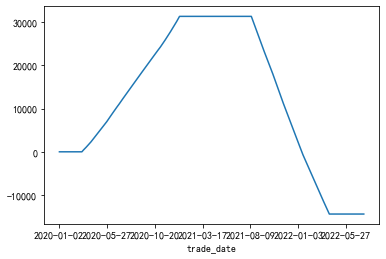

In [55]:
trade['return'].cumsum().plot()